# Prédire la gravité d'un accident de la route

Le site data.gouv (a.k.a. l'open data public) met à disposition les bases de données annuelles des accidents corporels de la circulation routière. Chaque année, quatre bases sont publiées : usagers, véhicules, lieux et caractéristiques.

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

La variable qui nous intéresse est la gravité de l'accident, présente dans la base usagers. Elle peut prendre les valeurs suivantes (code dans la base entre parenthèses) : indemne (1), tué (2), blessé hospitalisé (3) et blessé léger (4).

_Note : nous avons recodé la variable par ordre de gravité pour obtenir des résultats intermédiaires et finaux plus intuitifs. Cela donne : indemne (1), blessé léger (2), blessé hospitalisé (3), tué (4)._

On charge dans un premier temps tous les packages nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import et nettoyage des données

Nous avons choisi de charger les bases existantes sur les quatre dernières années, de 2019 à 2022.

In [2]:
df_usagers_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a", sep=";")
df_vehicules_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e", sep=";")
df_lieux_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434", sep=";")
df_caracs_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b", sep=";")

df_usagers_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee", sep=";")
df_vehicules_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a66be22f-c346-49af-b196-71df24702250", sep=";")
df_lieux_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e85c41f7-d4ea-4faf-877f-ab69a620ce21", sep=";")
df_caracs_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0", sep=";")

df_usagers_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028", sep=";")
df_vehicules_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667", sep=";")
df_lieux_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6", sep=";")
df_caracs_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a", sep=";")

c:\Users\nahta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


On importe également un module qui permet de nettoyer les données une première fois (il s'agit essentiellement de recoder les modalités de variables qui sont peu éloquentes).

In [3]:
from data_cleaning import *

On fait passer tous les dataframes par le nettoyage.

In [4]:
df_usagers_22 = clean_df_usagers(df_usagers_22)
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)
df_lieux_22 = clean_df_lieux(df_lieux_22)
df_caracs_22 = clean_df_caracs(df_caracs_22)

df_usagers_21 = clean_df_usagers(df_usagers_21)
df_vehicules_21 = clean_df_vehicules(df_vehicules_21)
df_lieux_21 = clean_df_lieux(df_lieux_21)
df_caracs_21 = clean_df_caracs(df_caracs_21)

df_usagers_20 = clean_df_usagers(df_usagers_20)
df_vehicules_20 = clean_df_vehicules(df_vehicules_20)
df_lieux_20 = clean_df_lieux(df_lieux_20)
df_caracs_20 = clean_df_caracs(df_caracs_20)

df_usagers_19 = clean_df_usagers(df_usagers_19)
df_vehicules_19 = clean_df_vehicules(df_vehicules_19)
df_lieux_19 = clean_df_lieux(df_lieux_19)
df_caracs_19 = clean_df_caracs(df_caracs_19)

## Jointure

À présent, nous effectuons une jointure pour obtenir une unique base avec une ligne par victime (la base usagers est le dénominateur commun : on peut avoir plusieurs victimes pour un même véhicule, plusieurs victimes pour un même lieu ou pour un même accident).

Réalisons la jointure pour l'année 2022 par étapes.

On s'assure qu'on a bien autant d'observations dont le triplet `(Num_Acc, id_vehicule, num_veh)` est unique dans les bases `usagers` et `véhicules`.

In [5]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [6]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [7]:
(~df_vehicules_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

À présent, on peut procéder à la jointure à l'aide de `pd.merge`. On joint d'abord les bases `usagers` et `vehicules` sur `(Num_Acc, id_vehicule, num_veh)`, puis on joint également les bases `lieux` et `caracs` sur l'identifiant de l'accident, codé par `Num_Acc`.

In [8]:
df_merged_22 = pd.merge(pd.merge(pd.merge(df_usagers_22, df_vehicules_22, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_22, on="Num_Acc"), df_caracs_22, on="Num_Acc")

In [9]:
len(df_merged_22)

126662

On retombe bien sur un total de 126 662 observations, soit la longueur de la base usagers.

On fait de même pour les autres années.

In [10]:
df_merged_21 = pd.merge(pd.merge(pd.merge(df_usagers_21, df_vehicules_21, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_21, on="Num_Acc"), df_caracs_21, on="Num_Acc")

df_merged_20 = pd.merge(pd.merge(pd.merge(df_usagers_20, df_vehicules_20, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_20, on="Num_Acc"), df_caracs_20, on="Num_Acc")

df_merged_19 = pd.merge(pd.merge(pd.merge(df_usagers_19, df_vehicules_19, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_19, on="Num_Acc"), df_caracs_19, on="Num_Acc")

On concatène le tout pour obtenir une base unifiée.

In [74]:
df_merged = pd.concat([df_merged_22, df_merged_21, df_merged_20, df_merged_19], ignore_index=True)

In [75]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494182 entries, 0 to 494181
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      494182 non-null  int64  
 1   id_usager    255910 non-null  object 
 2   id_vehicule  494182 non-null  object 
 3   num_veh      494182 non-null  object 
 4   place        494157 non-null  float64
 5   catu         494182 non-null  object 
 6   grav         493881 non-null  float64
 7   sexe         488376 non-null  object 
 8   an_nais      488241 non-null  float64
 9   trajet       360809 non-null  object 
 10  secu1        388294 non-null  object 
 11  secu2        59943 non-null   object 
 12  secu3        4029 non-null    object 
 13  locp         277429 non-null  float64
 14  actp         222449 non-null  object 
 15  etatp        37936 non-null   object 
 16  senc         492526 non-null  float64
 17  catv         493108 non-null  float64
 18  obs          493991 non-

## Nettoyages

### Nettoyage de variables

Comme annoncé dans l'introduction, nous avons recodons la variable `grav` par ordre de gravité pour obtenir des résultats intermédiaires et finaux plus intuitifs. Cela donne : indemne (1), blessé léger (2), blessé hospitalisé (3), tué (4).

In [76]:
df_merged["grav"].replace({2: 4, 4: 2}, inplace=True)

`vma` indique la vitesse maximale autorisée sur la voie empruntée. Les vitesses supérieures à 130 sont donc des erreurs. Puisqu'il n'existe aucune autre base recensan tles vitesses (ce qui permettrait d'imputer les bonnes valeurs à l'aide d'une jointure), on les remplace par des NaN.

Les valeurs très faibles comme 1 sont suspectes, mais dans le doute il est préférable de les conserver.

In [77]:
df_merged.loc[df_merged['vma'] > 130, 'vma'] = np.nan

On met la variable `heure` au format approprié.

In [78]:
df_merged['heure'] = pd.to_datetime(df_merged['hrmn'], format='%H:%M').dt.time

Les variables `lat` et `long` étaient codées selon les normes typographiques françaises et donc non reconnues comme des nombres. On les transforme en float.

In [79]:
df_merged['lat'] = df_merged['lat'].str.replace(',', '.').astype(float)
df_merged['long'] = df_merged['long'].str.replace(',', '.').astype(float)

On élimine l'unique `NaN` de la variable `grav`.

In [80]:
df_merged.dropna(subset=['grav'], inplace=True)

### Suppression de variables

On élimine d'emblée certaines variables qui ne serviront pas au modèle de prédiction de la gravité.

In [81]:
df_merged.drop(["Num_Acc", "id_usager", "id_vehicule", "num_veh", "voie", "v1", "v2",
                "dep", "com", "adr", "lat", "long", "pr", "pr1", "an"], axis=1, inplace=True)

On peut également enlever `lartpc` et `occutc` qui ont trop de `NaN`.

In [82]:
df_merged.drop(["lartpc", "occutc"], axis=1, inplace=True)

### Ajout de variables

On crée une variable `h` (pour heure), plus pratique par la suite pour certains plots.

In [83]:
df_merged["h"] = df_merged["heure"]. apply(lambda x: x.hour)

On crée une nouvelle variable de type booléen pour chaque équipement de sécurité (au lieu d'avoir trois colonnes recensant les équipements).

Note : pour la modalité `gants + airbag`, on fait comme si cela signifiait qu'à la fois les gants et l'airbag étaient présents.

In [84]:
for equipement in ["ceinture", "casque", "dispositif enfants", "gilet réfléchissant",
                   "airbag", "gants", "gants + airbag", "autre"]:
    df_merged[equipement] = df_merged[["secu1", "secu2", "secu3"]].isin([equipement]).any(axis=1)

df_merged["airbag"] = df_merged["airbag"] | df_merged["gants + airbag"]
df_merged["gants"] = df_merged["gants"] | df_merged["gants + airbag"]
df_merged.drop("gants + airbag", axis=1, inplace=True)

### Général

On convertit les valeurs `-1` en `np.NaN`.

In [85]:
df_merged.replace(-1, np.nan, inplace=True)
df_merged.replace("-1", np.nan, inplace=True)
df_merged.replace(" -1", np.nan, inplace=True)

Voici les colonnes finales qui composent le dataframe.

In [86]:
df_merged.columns

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'catv_2', 'catr', 'circ', 'nbv', 'vosp', 'prof',
       'plan', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour', 'mois',
       'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'heure', 'h', 'ceinture',
       'casque', 'dispositif enfants', 'gilet réfléchissant', 'airbag',
       'gants', 'autre'],
      dtype='object')

Brève description des variables
- `place` : place occupée dans le véhicule par l'usager au moment de l'accident ; 1 conducteur, 10 piéton
- `sexe` : sexe de l'usager
- `an_nais` : année de naissance de l'usager
- `trajet` : motif du déplacement au moment de l'accident
- `secu` : présence et utilisation de tel équipement de sécurité
- `locp` : localisation du piéton
- `actp` : action du piéton
- `etatp` : piéton seul, accompagné ou en groupe
- `senc` : sens de circulation
- `catv` : catégorie du véhicule
- `obs` : obstacle fixe heurté
- `obsm` : obstacle mobile heurté
- `choc` : point de choc initial
- `manv` :
- `motor` :
- `catr` :
- `circ` :
- `nbv` :
- `vosp` :
- `prof` :
- `larrout` :
- `surf` :
- `infra` : 
- `situ` :
- `vma` :
- `jour` :
- `mois` :
- `hrmn` :
- `lum` :
- `agg` :
- `int` :
- `atm` :
- `col` :

# Statistiques descriptives

Petit truc qui sera utile pour la suite.

In [87]:
df_non_pieton = df_merged[df_merged["catu"]!="piéton"]
df_pieton = df_merged[df_merged["catu"]=="piéton"]


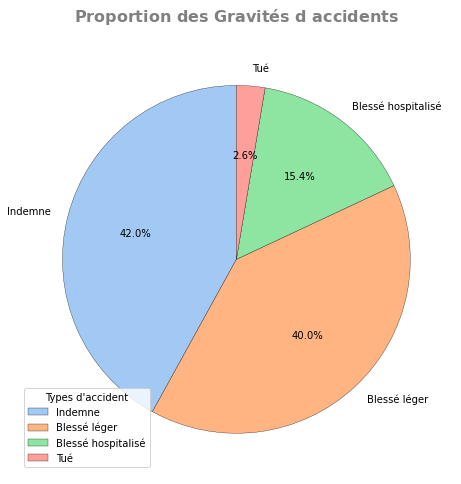

In [88]:
accident_counts = df_merged['grav'].value_counts()
labels_pie_chart = {1: 'Indemne', 2: 'Blessé léger', 3: 'Blessé hospitalisé', 4: 'Tué'}
accident_counts.index = accident_counts.index.map(labels_pie_chart)
colors = sns.color_palette('pastel')  
plt.figure(figsize=(8, 8))
plt.pie(accident_counts, labels=accident_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=1, edgecolor='black', linewidth=0.3)) # dict(width=1)
plt.title(r'$\bf{ Proportion\ des\ Gravités\ d\ accidents}$', fontsize=16, loc='center', pad=20, color='grey')
plt.legend(title='Types d\'accident', loc='lower left', bbox_to_anchor=(0.0005, 0.01))
plt.show() 

### `agg` [++]

On constate que
- la majorité des accidents de gravité 1 et 2 ont lieu en agglomération ;
- la majorité des accidents de gravité 3 et 4 ont lieu hors agglomération.


<AxesSubplot:xlabel='agg', ylabel='count'>

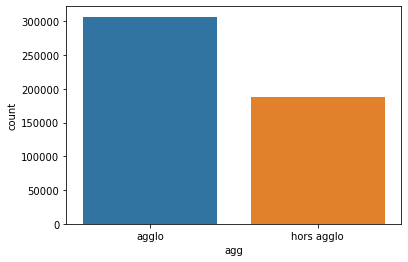

In [89]:
sns.countplot(data=df_merged, x="agg")

<AxesSubplot:xlabel='agg', ylabel='proportion'>

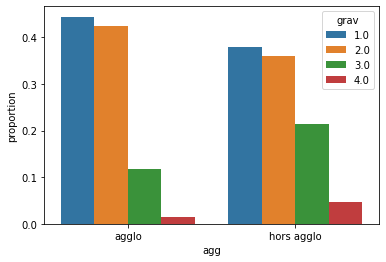

In [90]:
proportions = df_merged.groupby('agg')['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x='agg', y='proportion', hue='grav', data=proportions)

### `place` [-]

<AxesSubplot:xlabel='place', ylabel='count'>

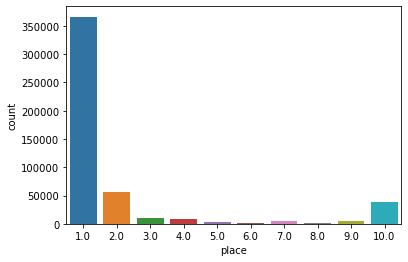

In [91]:
sns.countplot(data=df_merged, x="place")

<AxesSubplot:xlabel='place', ylabel='proportion'>

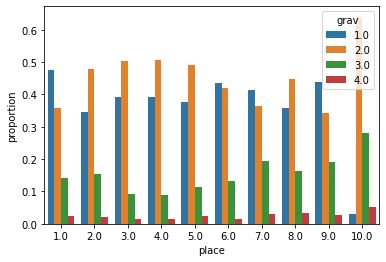

In [92]:
var = "place"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### `catu` [+++]

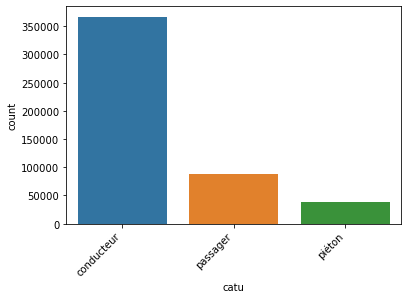

In [93]:
var = "catu"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

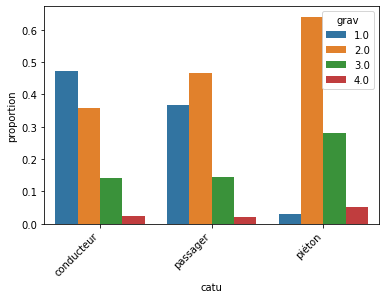

In [94]:
var = "catu"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `sexe` [++]

<AxesSubplot:xlabel='sexe', ylabel='count'>

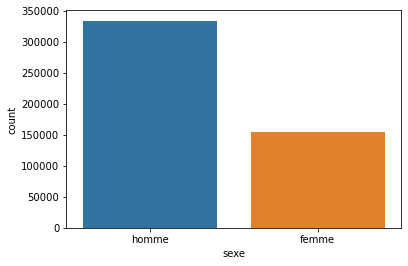

In [95]:
sns.countplot(data=df_merged, x="sexe")

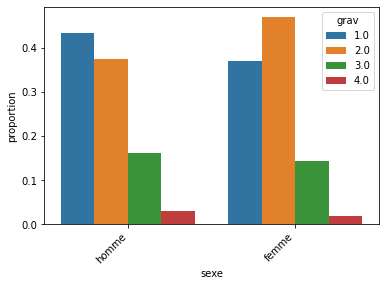

In [96]:
var = "sexe"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `an_nais` [+] (année de naissance)

<AxesSubplot:xlabel='an_nais', ylabel='Density'>

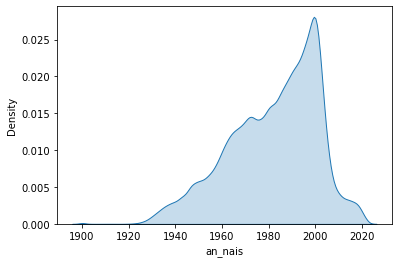

In [97]:
var = "an_nais"
sns.kdeplot(df_merged[var], fill=True)

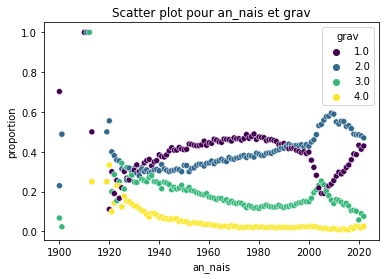

In [98]:
var = "an_nais"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [99]:
df_merged = df_merged[df_merged["an_nais"] >= 1930]

In [100]:
df_merged["ind_avant_1960"] = df_merged["an_nais"] < 1960
df_merged["ind_2002_2012"] = (df_merged["an_nais"] >= 2002) & (df_merged["an_nais"] <= 2012)

### `heure` [+, 2]

In [101]:
df_merged["heure"].value_counts()

18:00:00    6739
17:00:00    5895
17:30:00    5601
18:30:00    5537
19:00:00    5202
            ... 
04:41:00       3
04:24:00       3
03:36:00       3
03:59:00       2
03:31:00       2
Name: heure, Length: 1438, dtype: int64

In [102]:
df_merged["hrmn"]

0         16:15
1         16:15
2         08:34
3         08:34
4         17:15
          ...  
494177    07:50
494178    02:41
494179    15:20
494180    20:50
494181    20:50
Name: hrmn, Length: 486836, dtype: object

In [103]:
df_merged["heure"].apply(lambda x: x.hour)

0         16
1         16
2          8
3          8
4         17
          ..
494177     7
494178     2
494179    15
494180    20
494181    20
Name: heure, Length: 486836, dtype: int64

<AxesSubplot:xlabel='h', ylabel='Density'>

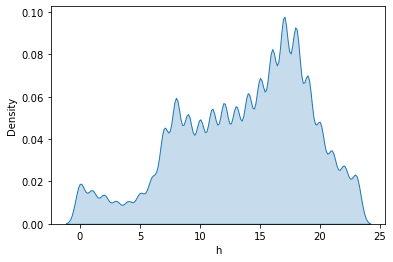

In [104]:
sns.kdeplot(df_merged["h"], fill=True)

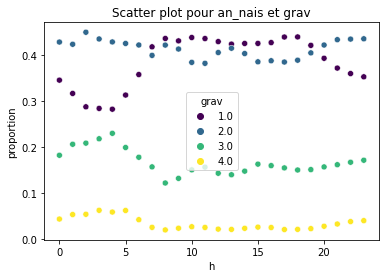

In [105]:
var = "h"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [106]:
df_merged["heure_2"] = np.where(df_merged["h"] < 7, 0,
                                np.where(df_merged["h"] >= 20, 1, 2))

### `nbv` [+, 2]

<AxesSubplot:xlabel='nbv', ylabel='count'>

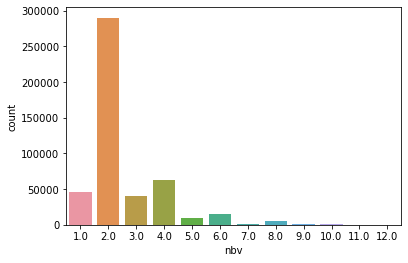

In [107]:
sns.countplot(data=df_merged, x="nbv")

<AxesSubplot:xlabel='nbv', ylabel='proportion'>

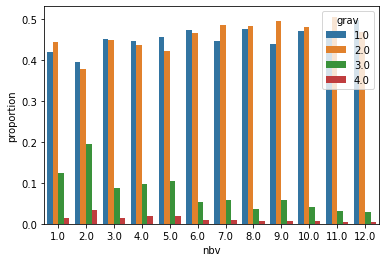

In [108]:
var = "nbv"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

In [109]:
df_merged["nbv_2"] = np.where(df_merged["nbv"].isin([2]), 0,
                              np.where(df_merged["nbv"].isin([1, 3, 4, 5]), 1, 2))

### `trajet` [+]

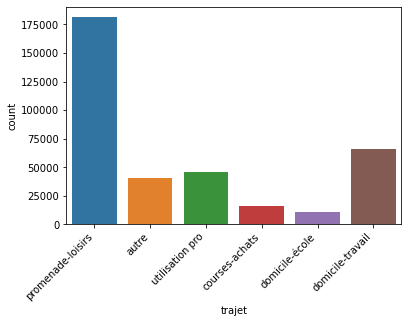

In [110]:
sns.countplot(data=df_merged, x="trajet")
plt.xticks(rotation=45, ha='right')
plt.show()

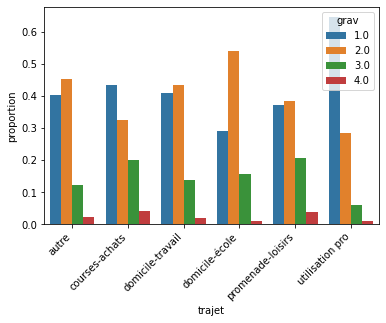

In [111]:
var = "trajet"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)
plt.xticks(rotation=45, ha='right')
plt.show()

### `lum` [+, 2]

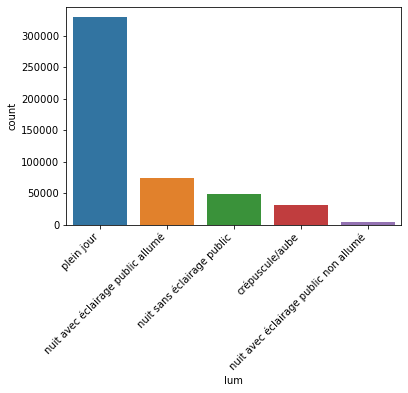

In [112]:
var = "lum"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

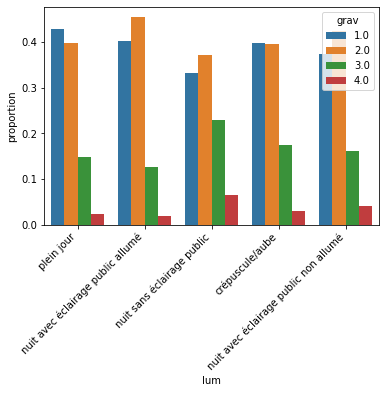

In [113]:
var = "lum"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [114]:
df_merged["lum_2"] = np.where(df_merged["lum"].isin(["plein jour", "nuit avec éclairage public allumé"]), 1, 0)

### `surf` [-] (surface)

Il n'y a que 2 modalités aux effectifs importants, et leur profil de gravité est très similaire...

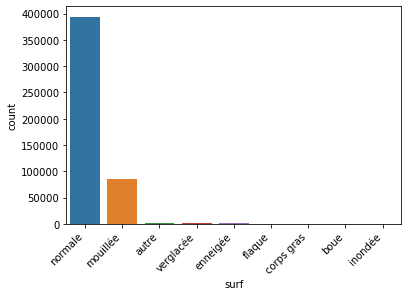

In [115]:
var = "surf"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

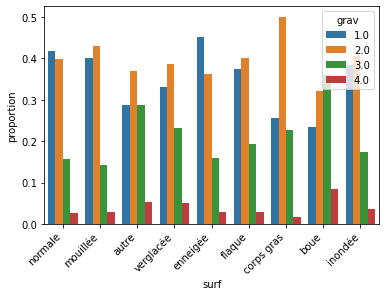

In [116]:
var = "surf"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `atm` [-] (conditions atmosphériques)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

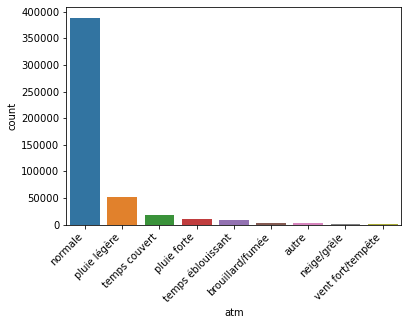

In [117]:
var = "atm"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

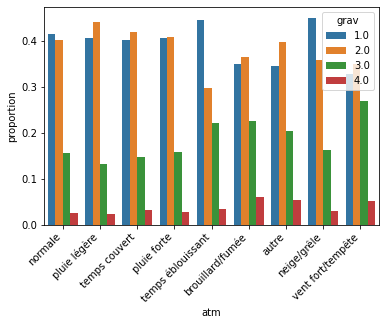

In [118]:
var = "atm"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `int` [-] (intersection)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

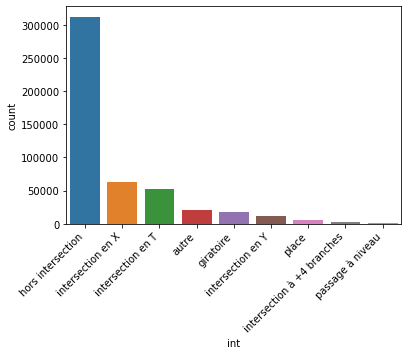

In [119]:
var = "int"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

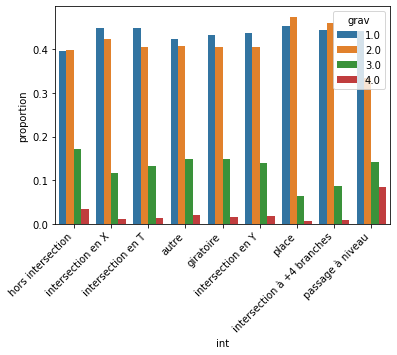

In [120]:
var = "int"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `col` [+, 2] (collision)

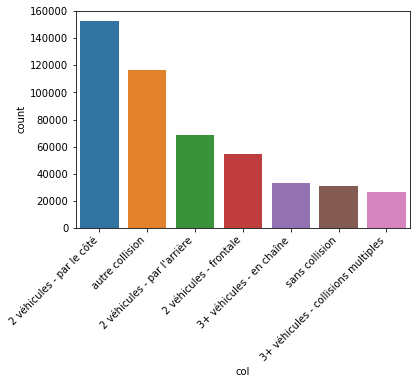

In [121]:
var = "col"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

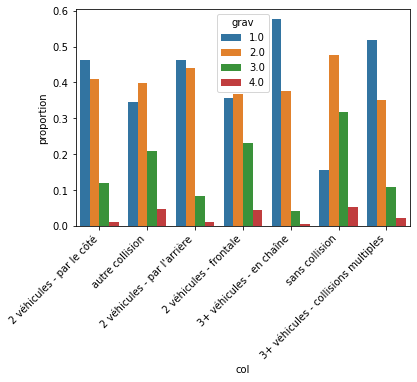

In [122]:
var = "col"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [123]:
df_merged["col_2"] = np.where(df_merged["col"].isin(["autre collision", "2 véhicules - frontale", "sans collision"]), 1, 0)

### `catr` [+, 2] (catégorie route)

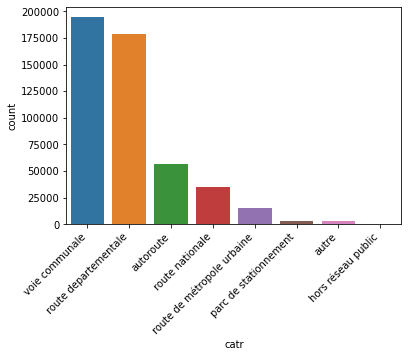

In [124]:
var = "catr"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

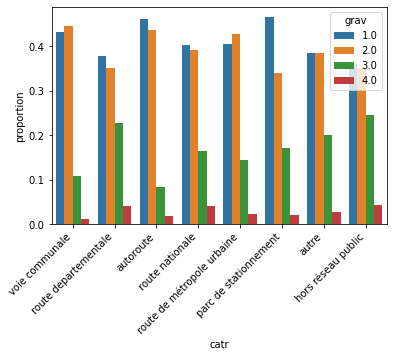

In [125]:
var = "catr"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [126]:
df_merged["catr_2"] = np.where(df_merged["catr"].isin(["route départementale", "hors réseau public"]), 0,
                               np.where(df_merged["catr"].isin(["route nationale", "route de métropole urbaine",
                                                               "parc de stationnement", "autre"]), 1, 2))

### `circ` [++] (régime de circulation)

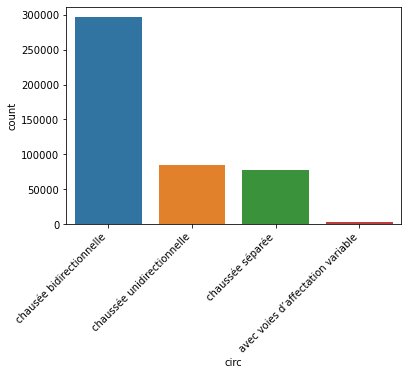

In [127]:
var = "circ"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

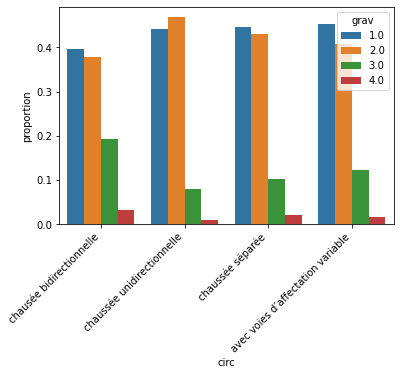

In [128]:
var = "circ"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `vosp` [-] (voie réservée)

Trop de `NaN` et profils de gravités trop similaires.

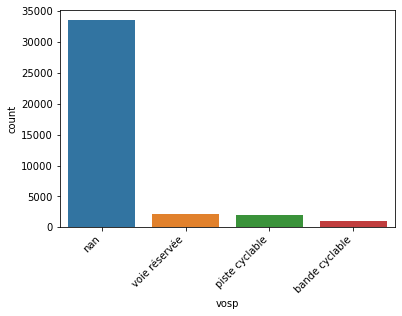

In [129]:
var = "vosp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

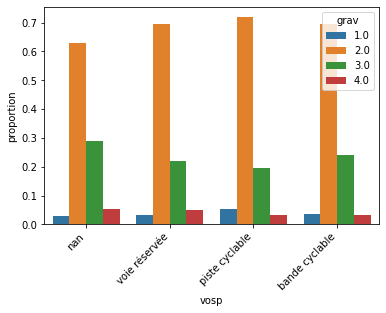

In [130]:
var = "vosp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `prof` [-] (déclivité de la route)

Les modalités ont des profils de gravité trop similaires.

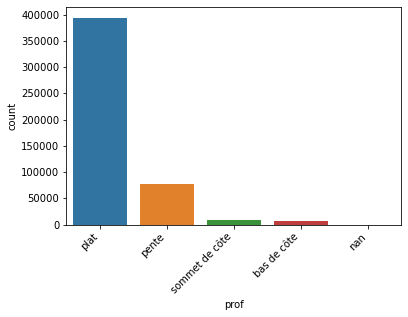

plat              394512
pente              76698
sommet de côte      8462
bas de côte         7086
nan                   78
Name: prof, dtype: int64

In [131]:
var = "prof"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

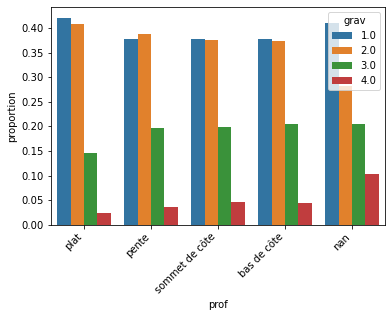

In [132]:
var = "prof"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `plan` [+, 2] (tracé en plan)

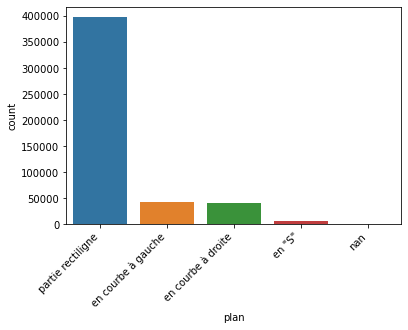

partie rectiligne     397907
en courbe à gauche     42301
en courbe à droite     40459
en "S"                  6109
nan                       60
Name: plan, dtype: int64

In [133]:
var = "plan"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

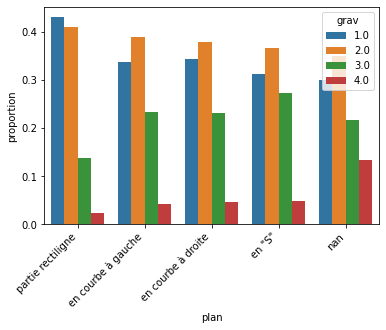

In [134]:
var = "plan"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [135]:
df_merged["plan_2"] = np.where(df_merged["plan"].isin(["partie rectiligne"]), 1, 0)

### `infra` [-] (aménagement, infrastructure)

Il y a _a priori_ trop peu de non `NaN` pour en tirer quelque chose d'intéressant, et de toute façon les profils de gravité sont assez similaires.

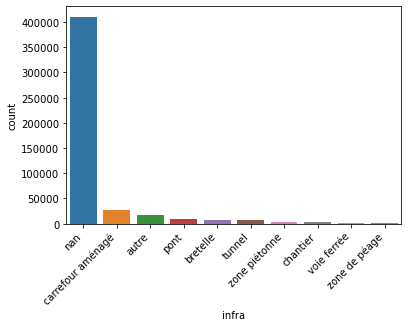

nan                  410498
carrefour aménagé     27761
autre                 16992
pont                   8845
bretelle               6748
tunnel                 6393
zone piétonne          3962
chantier               3739
voie ferrée            1531
zone de péage           367
Name: infra, dtype: int64

In [136]:
var = "infra"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

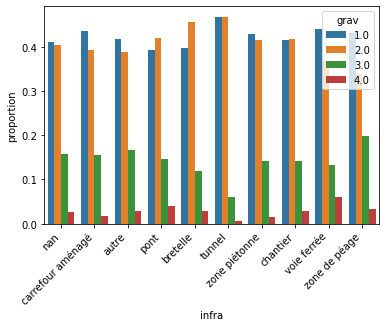

In [137]:
var = "infra"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `situ` [+, 2]

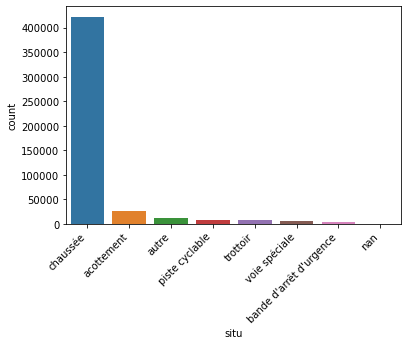

chaussée                   422258
acottement                  26228
autre                       12088
piste cyclable               8582
trottoir                     7585
voie spéciale                5542
bande d'arrêt d'urgence      4280
nan                           273
Name: situ, dtype: int64

In [138]:
var = "situ"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

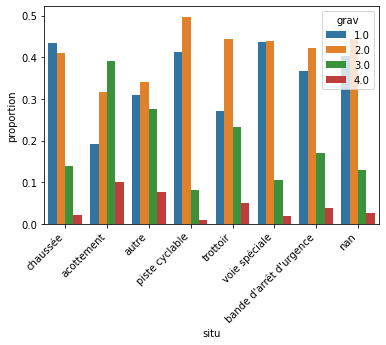

In [139]:
var = "situ"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [140]:
df_merged["situ_2"] = np.where(df_merged["situ"].isin(["acottement"]), 0, 
                               np.where(df_merged["situ"].isin(["autre", "trottoir"]), 1, 2))

### `obs` [-] (obstacle fixe heurté)

Pas très intéressant, quasi que des "sans objet" puisque ce sont essentiellement des obstacles mobiles.

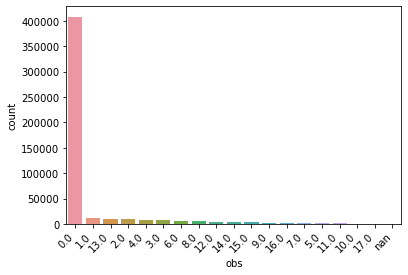

0.0     408028
1.0      11516
13.0     10077
2.0       8767
4.0       7491
3.0       7403
6.0       6573
8.0       6491
12.0      3809
14.0      3622
15.0      3301
9.0       2577
16.0      2223
7.0       1663
5.0        955
11.0       921
10.0       639
17.0       627
nan        153
Name: obs, dtype: int64

In [141]:
var = "obs"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

### `obsm` [+, 2] (type d'obstacle heurté)

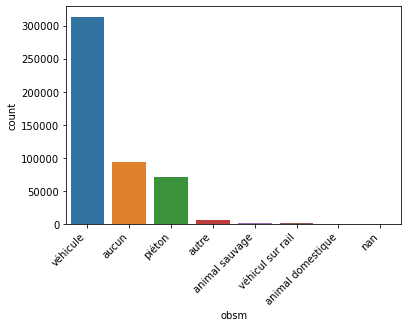

véhicule             313447
aucun                 94173
piéton                70616
autre                  6249
animal sauvage         1278
véhicul sur rail        473
animal domestique       377
nan                     223
Name: obsm, dtype: int64

In [142]:
var = "obsm"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

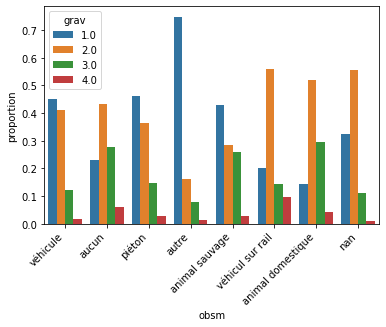

In [143]:
var = "obsm"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [144]:
df_merged["obsm_2"] = np.where(df_merged["obsm"].isin(["aucun"]), 0, 
                               np.where(df_merged["obsm"].isin(["autre"]), 1, 2))

### `choc` [+, 2 à venir]

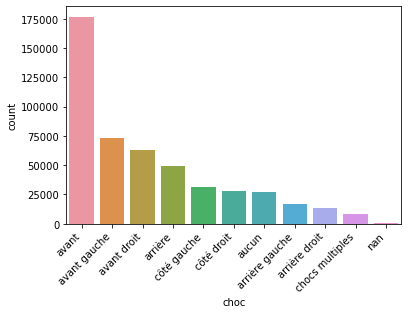

avant              176763
avant gauche        72826
avant droit         63136
arrière             48960
côté gauche         31623
côté droit          27892
aucun               26846
arrière gauche      16935
arrière droit       13517
chocs multiples      8146
nan                   192
Name: choc, dtype: int64

In [145]:
var = "choc"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

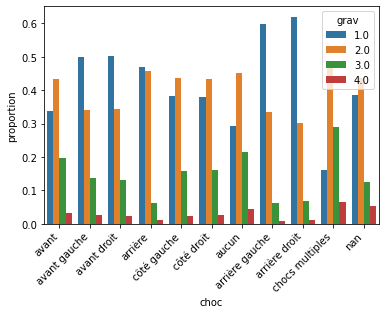

In [146]:
var = "choc"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `manv` [+, réfléchir]

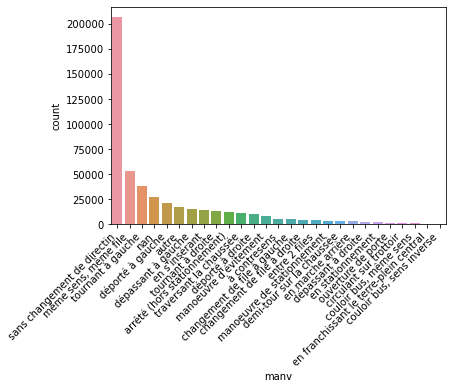

sans changement de directin               206884
même sens, même file                       53753
tournant à gauche                          38275
nan                                        26980
déporté à gauche                           21001
autre                                      17200
dépassant à gauche                         15712
en s'insérant                              13909
tournant à droite                          13104
arrêté (hors stationnement)                12429
traversant la chaussée                     11706
déporté à droite                           10551
manoeuvre d'évitement                       7859
à contresens                                4981
changement de file à gauche                 4971
changement de file à droite                 4414
entre 2 files                               4384
manoeuvre de stationnement                  3165
demi-tour sur la chaussée                   3063
en marche arrière                           3024
dépassant à droite  

In [147]:
var = "manv"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

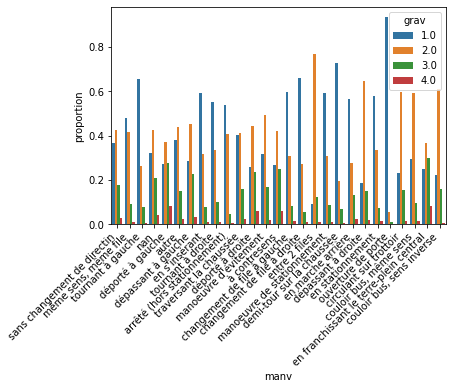

In [148]:
var = "manv"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `motor` [+, réfléchir] (motorisation du véhicule)

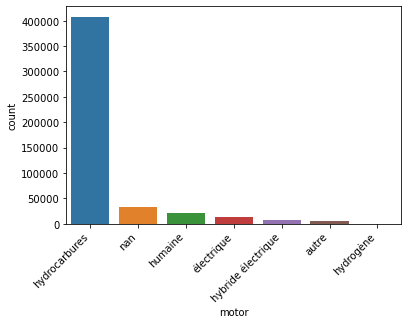

hydrocarbures         407859
nan                    32625
humaine                20717
électrique             13147
hybride électrique      7886
autre                   4304
hydrogène                298
Name: motor, dtype: int64

In [149]:
var = "motor"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

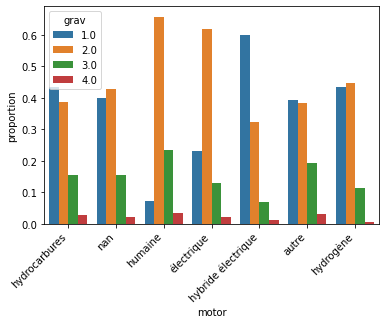

In [150]:
var = "motor"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `locp` [-] (localisation du piéton)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

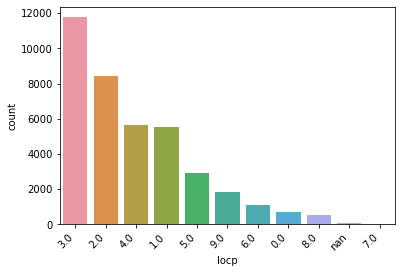

3.0    11762
2.0     8424
4.0     5671
1.0     5509
5.0     2924
9.0     1837
6.0     1108
0.0      688
8.0      544
nan       82
7.0       42
Name: locp, dtype: int64

In [151]:
var = "locp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

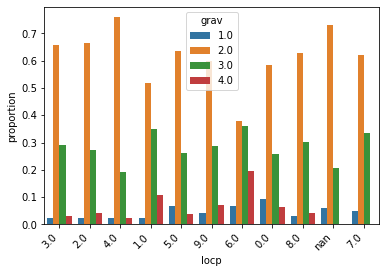

In [152]:
var = "locp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `actp` [-] (action du piéton)

La variable est trop peu variée pour être intéressante à exploiter.

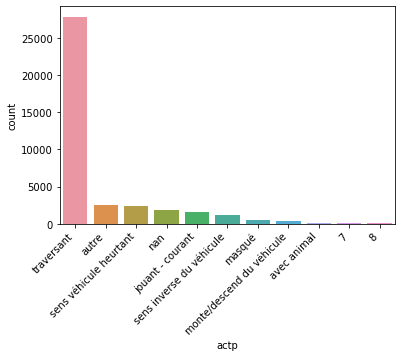

traversant                   27870
autre                         2523
sens véhicule heurtant        2440
nan                           1903
jouant - courant              1531
sens inverse du véhicule      1156
masqué                         529
monte/descend du véhicule      421
avec animal                    106
7                               60
8                               52
Name: actp, dtype: int64

In [153]:
var = "actp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

### `etatp` [-]

Profils de gravité trop similaires.

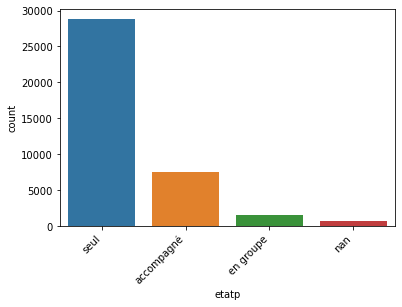

seul          28815
accompagné     7558
en groupe      1509
nan             709
Name: etatp, dtype: int64

In [154]:
var = "etatp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

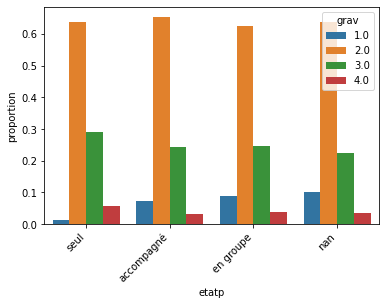

In [155]:
var = "etatp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `jour` [-]

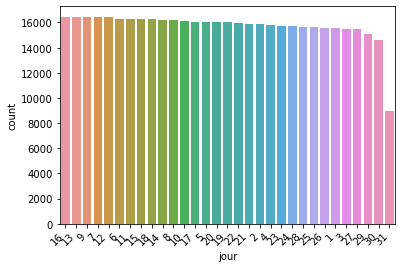

16    16462
13    16456
9     16452
7     16431
12    16415
6     16298
11    16261
15    16237
18    16235
14    16221
8     16175
10    16092
17    16045
5     16036
20    16028
19    16011
22    15963
21    15881
2     15842
4     15812
23    15730
24    15679
28    15630
25    15630
26    15581
1     15572
3     15509
27    15505
29    15107
30    14608
31     8932
Name: jour, dtype: int64

In [156]:
var = "jour"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

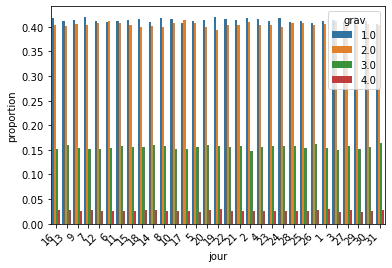

In [157]:
var = "jour"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

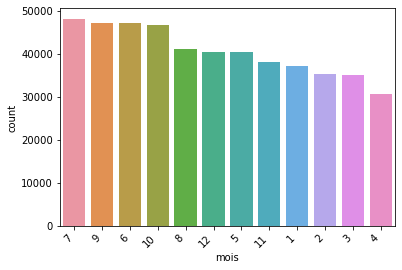

7     48159
9     47089
6     47058
10    46591
8     41071
12    40432
5     40338
11    38041
1     37211
2     35304
3     34986
4     30556
Name: mois, dtype: int64

In [158]:
var = "mois"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

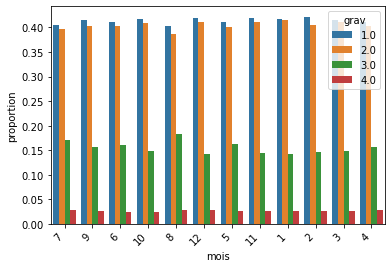

In [159]:
var = "mois"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `catv`[+]

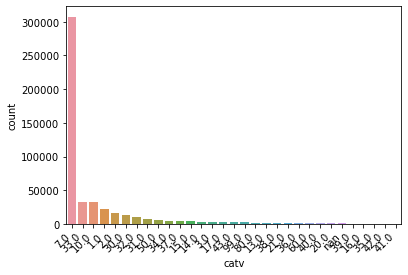

7.0     307402
33.0     33111
10.0     33065
1.0      21974
2.0      16131
30.0     13936
32.0     10116
31.0      7439
50.0      5726
34.0      4899
37.0      4499
15.0      3898
14.0      3308
3.0       3131
17.0      2837
43.0      2374
99.0      2162
80.0      1935
13.0      1756
38.0      1676
21.0      1062
36.0       890
60.0       797
40.0       760
20.0       682
nan        666
39.0       204
16.0       138
35.0       109
42.0        95
41.0        58
Name: catv, dtype: int64

In [160]:
var = "catv"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

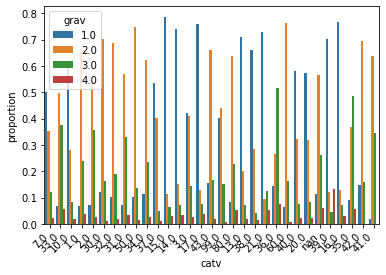

In [161]:
var = "catv"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

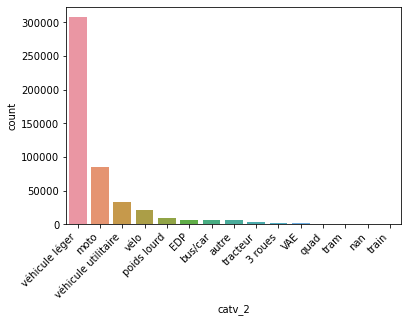

véhicule léger         307402
moto                    85632
véhicule utilitaire     33065
vélo                    21974
poids lourd              8962
EDP                      6523
bus/car                  6175
autre                    5975
tracteur                 4037
3 roues                  2527
VAE                      1935
quad                      999
tram                      760
nan                       666
train                     204
Name: catv_2, dtype: int64

In [162]:
var = "catv_2"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

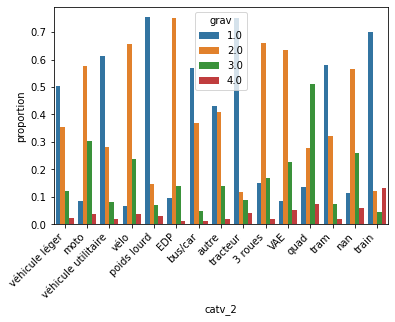

In [163]:
var = "catv_2"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

## Equipements

### `ceinture` [+++]

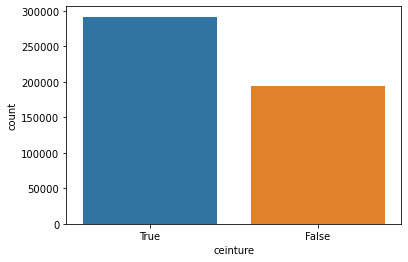

True     291921
False    194915
Name: ceinture, dtype: int64

In [164]:
var = "ceinture"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

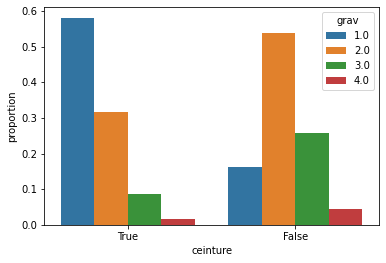

In [165]:
var = "ceinture"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `dispositif enfants` [-]

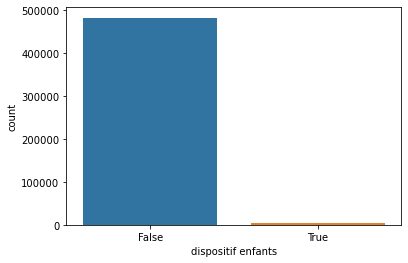

False    483139
True       3697
Name: dispositif enfants, dtype: int64

In [166]:
var = "dispositif enfants"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

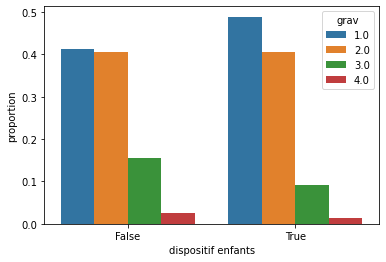

In [167]:
var = "dispositif enfants"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `casque` [+++]

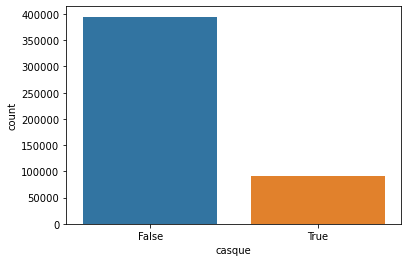

False    394789
True      92047
Name: casque, dtype: int64

In [168]:
var = "casque"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

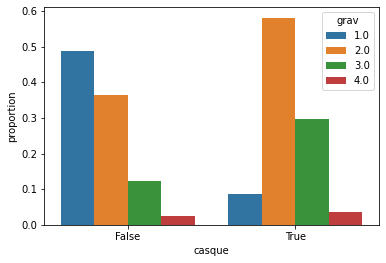

In [169]:
var = "casque"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `airbag` [-]

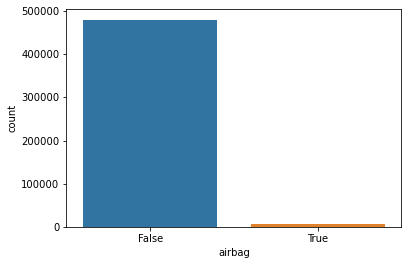

False    480144
True       6692
Name: airbag, dtype: int64

In [170]:
var = "airbag"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

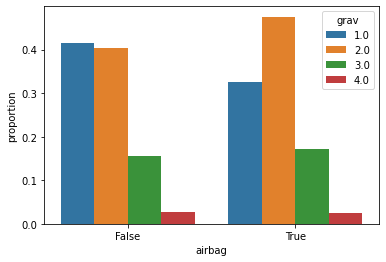

In [171]:
var = "airbag"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `gilet réfléchissant`

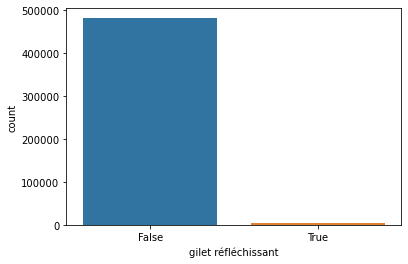

False    481593
True       5243
Name: gilet réfléchissant, dtype: int64

In [172]:
var = "gilet réfléchissant"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

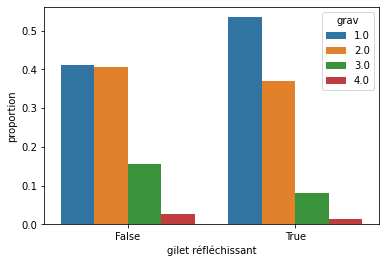

In [173]:
var = "gilet réfléchissant"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `gants`

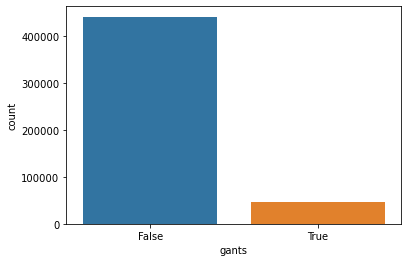

False    440632
True      46204
Name: gants, dtype: int64

In [174]:
var = "gants"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

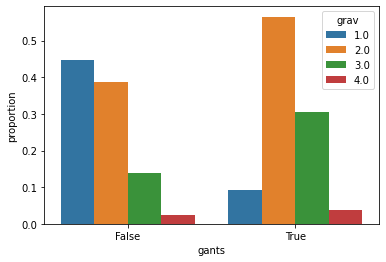

In [175]:
var = "gants"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `autre`

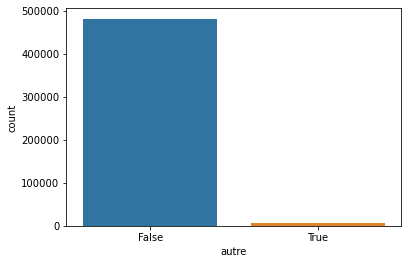

False    481342
True       5494
Name: autre, dtype: int64

In [176]:
var = "autre"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

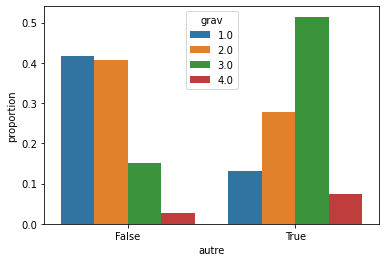

In [177]:
var = "autre"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

# Modèles

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

### MCO


In [179]:
# création de variable catégorielle pertinent en vue de la regression 
df_merged["moto"]=np.where(df_merged['catv_2'] == 'moto', 1, 0).astype(int)
df_merged["vélo"]=np.where(df_merged['catv_2'] == 'vélo', 1, 0).astype(int)
df_merged["poids lourd"]=np.where(df_merged['catv_2'] == 'poids lourd', 1, 0).astype(int)
df_merged["poids lourd"]=np.where(df_merged['catv_2'] == 'poids lourd', 1, 0).astype(int)

In [180]:
# au vue des stats descriptives ces variables semble particuliérment déterminantes
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv_2", "trajet", "lum_2", "col_2", 
                        "catr_2", "circ", "plan_2", "situ_2", "obsm_2", "ceinture","obsm","casque","gants","moto","vélo","poids lourd"]
df_elem1 = df_merged[["grav"] + numeric_features + categorical_features]
df_elem1.dropna(inplace=True)
df_elem1

c:\Users\nahta\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,grav,an_nais,h,vma,agg,catu,sexe,nbv_2,trajet,lum_2,...,plan_2,situ_2,obsm_2,ceinture,obsm,casque,gants,moto,vélo,poids lourd
0,3.0,2008.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,...,1,2,2,False,véhicule,True,False,1,0,0
1,1.0,1948.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,...,1,2,2,True,véhicule,False,False,0,0,0
2,2.0,1988.0,8,50.0,agglo,conducteur,homme,0,autre,1,...,1,2,2,True,véhicule,False,False,0,0,0
3,1.0,1970.0,8,50.0,agglo,conducteur,homme,0,utilisation pro,1,...,1,2,2,True,véhicule,False,False,0,0,0
7,2.0,1967.0,18,30.0,agglo,piéton,femme,1,promenade-loisirs,1,...,1,2,2,False,piéton,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,9,130.0,hors agglo,passager,homme,1,promenade-loisirs,1,...,1,2,2,True,véhicule,False,False,0,0,0
494175,1.0,1972.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,...,1,2,2,True,véhicule,False,False,0,0,0
494176,2.0,1964.0,7,90.0,hors agglo,conducteur,homme,0,domicile-travail,1,...,1,2,2,True,véhicule,False,False,0,0,0
494177,2.0,1988.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,...,1,2,2,True,véhicule,False,False,0,0,0


Encodage pour  la régression linéaire. création de variables binaires et conversion de format non prix par stat models en int 

In [181]:
# Binarisation 
df_elem1_bin=pd.get_dummies(df_elem1,columns=["agg", "catu", "sexe", "nbv_2", "trajet", "lum_2", "col_2", 
                        "catr_2", "circ", "plan_2", "situ_2", "obsm_2","obsm",],drop_first=True )# on drop pour éviter la colinéarité parfaite

In [182]:
# Conversions 
df_elem1_bin["an_nais"]=df_elem1_bin["an_nais"].astype(int)   # Statmodels ne prends les format DT.time  
df_elem1_bin['ceinture'] = df_elem1_bin['ceinture'].astype(int)  # ni les booléen il s'agit déja variables binaires
df_elem1_bin['casque'] = df_elem1_bin['casque'].astype(int) # idem
df_elem1_bin['gants'] = df_elem1_bin['gants'].astype(int)  # idem
df_elem1_bin.dropna(inplace=True)
df_elem1_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337449 entries, 0 to 494178
Data columns (total 39 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   grav                             337449 non-null  float64
 1   an_nais                          337449 non-null  int32  
 2   h                                337449 non-null  int64  
 3   vma                              337449 non-null  float64
 4   ceinture                         337449 non-null  int32  
 5   casque                           337449 non-null  int32  
 6   gants                            337449 non-null  int32  
 7   moto                             337449 non-null  int32  
 8   vélo                             337449 non-null  int32  
 9   poids lourd                      337449 non-null  int32  
 10  agg_hors agglo                   337449 non-null  uint8  
 11  catu_passager                    337449 non-null  uint8  
 12  ca

In [183]:
df_elem1_bin

,grav,an_nais,h,vma,ceinture,casque,gants,moto,vélo,poids lourd,...,situ_2_1,situ_2_2,obsm_2_1,obsm_2_2,obsm_animal sauvage,obsm_aucun,obsm_autre,obsm_piéton,obsm_véhicul sur rail,obsm_véhicule
0,3.0,2008,16,50.0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
1,1.0,1948,16,50.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
2,2.0,1988,8,50.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
3,1.0,1970,8,50.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
7,2.0,1967,18,30.0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968,9,130.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
494175,1.0,1972,7,90.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
494176,2.0,1964,7,90.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
494177,2.0,1988,7,90.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


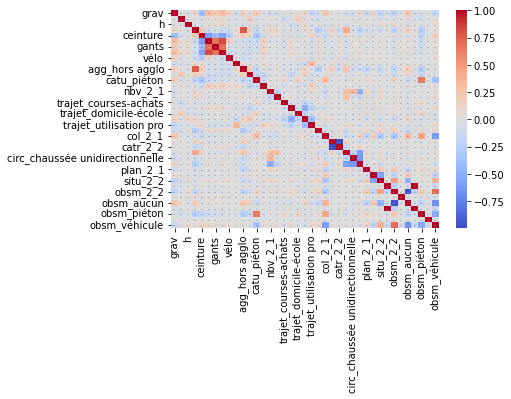

In [184]:
# Matrice de corrélation 
g = sns.heatmap(df_elem1_bin.corr(), cmap='coolwarm', annot=True, fmt=".2f",annot_kws={'size': 0.2})

Mettre toutes les variables en numériques en créant df_elem2_bin sinon message d'erreur en tournant l'ols

In [185]:
df_elem2_bin = df_elem1_bin.astype(int)

In [186]:
# Regression linéaire avec l'ensemble des variables df_elem1
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary2())

c:\Users\nahta\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.351      
Dependent Variable:     grav                 AIC:                    669904.9181
Date:                   2023-12-25 10:22     BIC:                    670301.8974
No. Observations:       337449               Log-Likelihood:         -3.3492e+05
Df Model:               36                   F-statistic:            5068.      
Df Residuals:           337412               Prob (F-statistic):     0.00       
R-squared:              0.351                Scale:                  0.42623    
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------
const                            5.5842   0.0979  57.0459 0.0000  5.3923  5.7761
an_nais                         -0.0029   0.0001 -44.

In [187]:
#selection du meilleur nombr de covariables  à l'aide du R carré ajusté 
y = df_elem2_bin['grav']
X = df_elem2_bin.drop('grav', axis=1)
liste_r_carre_ajustes = []
for nb_variables in range(len(X.columns)):
    X_loop =  X.iloc[ :,:nb_variables+1]
    X_loop = sm.add_constant(X_loop)
    modele = sm.OLS(y,X_loop ).fit()
    liste_r_carre_ajustes.append(modele.rsquared_adj)

serie_r_carre_ajustes = pd.Series(liste_r_carre_ajustes)
serie_r_carre_ajustes.sort_values(ascending=False,)

c:\Users\nahta\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


36    0.350877
37    0.350876
35    0.350587
31    0.319557
34    0.319555
33    0.319555
32    0.319555
30    0.310754
29    0.308634
28    0.295957
27    0.293651
25    0.291505
26    0.291504
24    0.289604
23    0.289196
22    0.289188
21    0.289037
20    0.273690
19    0.269905
18    0.267709
17    0.262122
16    0.261771
15    0.261535
14    0.261407
13    0.256085
12    0.249621
11    0.247904
10    0.226823
9     0.224313
8     0.205831
7     0.200929
6     0.198735
5     0.197331
4     0.197275
3     0.192835
2     0.008288
1     0.000582
0     0.000040
dtype: float64

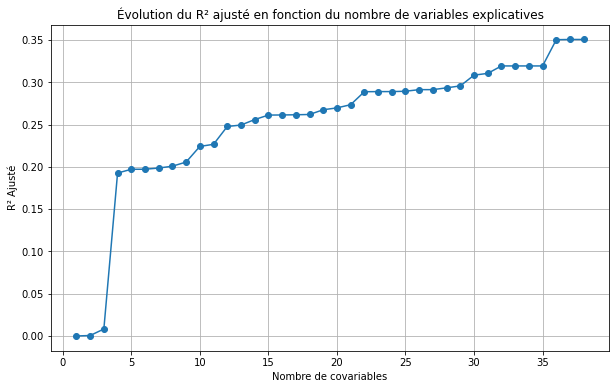

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(serie_r_carre_ajustes) + 1), serie_r_carre_ajustes, marker='o')
plt.title("Évolution du R² ajusté en fonction du nombre de variables explicatives")
plt.xlabel("Nombre de covariables")
plt.ylabel("R² Ajusté")
plt.grid(True)
plt.show()

Pour construire une régression linéaire avec le R-carré le plus élevé 
modèle plus pertinent : 

In [189]:
#nombre_de_covariables_le_plus_pertinent= serie_r_carre_ajustes.idxmax()
#X_R_carre_max=X.iloc[ :,:nombre_de_covariables_le_plus_pertinent]
#X_R_carre_max = sm.add_constant(X_R_carre_max)
#model = sm.OLS(y, X)
#results = model.fit()
#print(results.summary2())
#(modele.rsquared_adj)

## KNN

In [190]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [193]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [194]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.605383698956536, 0.724164758080253)

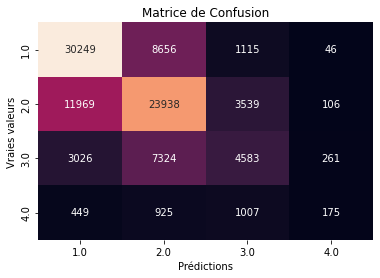

In [196]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

## SVC

Trop long à tourner.

In [23]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [24]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [25]:
from sklearn.svm import SVC
model = SVC(kernel="linear")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

## Arbre de décision

In [53]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture",
                        "casque", "dispositif enfants"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [54]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [55]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=14)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6434898812476588, 0.6764573378148538)

Voici les scores en cross-validation.

In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.3f}")

Cross-Validation Scores: [0.63698027 0.63489107 0.63610594 0.63371669 0.63381793]
Mean Accuracy: 0.635


[Text(0.5225409836065574, 0.9166666666666666, 'ceinture_True <= 0.5\ngini = 0.639\nsamples = 395104\nvalue = [165633, 158239, 60779, 10453]'),
 Text(0.26229508196721313, 0.75, 'agg_hors agglo <= 0.5\ngini = 0.628\nsamples = 160953\nvalue = [29562, 84302, 40266, 6823]'),
 Text(0.13114754098360656, 0.5833333333333334, 'catu_piéton <= 0.5\ngini = 0.58\nsamples = 117772\nvalue = [21850, 68969, 24222, 2731]'),
 Text(0.06557377049180328, 0.4166666666666667, 'obsm_piéton <= 0.5\ngini = 0.597\nsamples = 89022\nvalue = [21048, 49801, 16468, 1705]'),
 Text(0.03278688524590164, 0.25, 'motor_hydrocarbures <= 0.5\ngini = 0.568\nsamples = 81326\nvalue = [14609, 48706, 16323, 1688]'),
 Text(0.01639344262295082, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.04918032786885246, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09836065573770492, 0.25, 'choc_avant <= 0.5\ngini = 0.279\nsamples = 7696\nvalue = [6439, 1095, 145, 17]'),
 Text(0.08196721311475409, 0.08333333333333333, '\n  (...)  \n'),
 Text(0

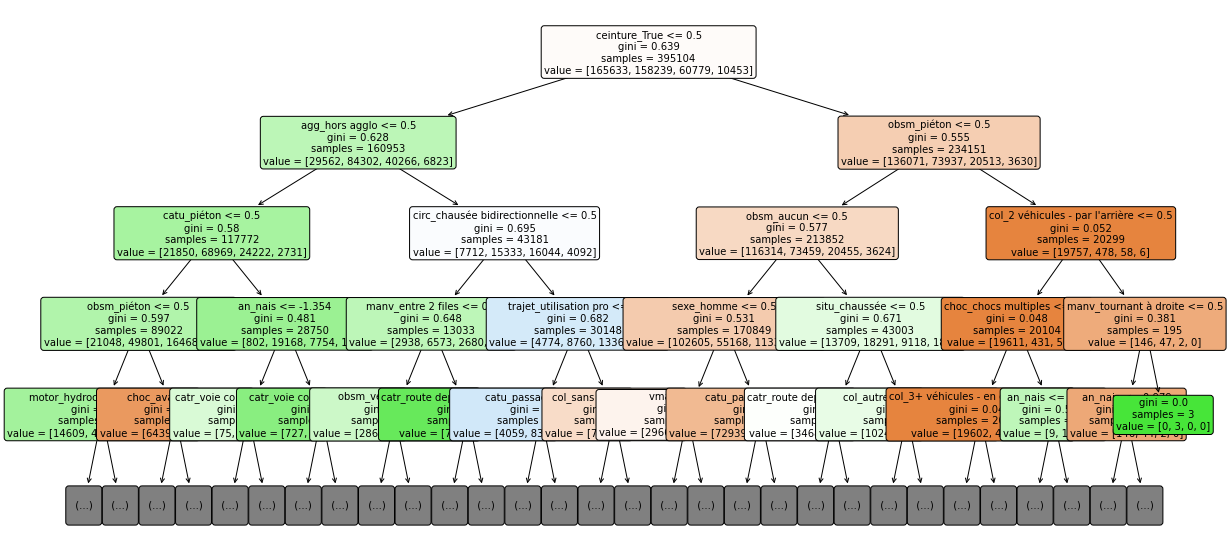

In [91]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=4, fontsize=10)

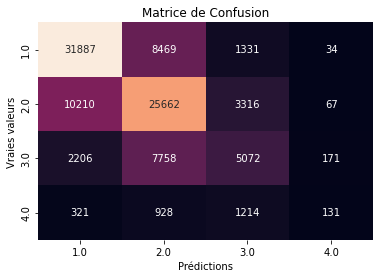

In [92]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

## Forêt aléatoire

In [119]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30, 
                               max_depth=20, 
                               random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6510624943053545, 0.7419970438163117)

In [120]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.3f}")

Cross-Validation Scores: [0.65413001 0.65244594 0.65228396 0.65157528 0.65154491]
Mean Accuracy: 0.652


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

# Random forest 2

In [127]:
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error


#séparation variables dépendantes et explicatives
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']

#division du jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#création du modèle Random Forest pour la régression
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42) #ajuster n_estimators au choix

#ajustement du modèle sur les données d'entraînement
random_forest_model.fit(X_train, y_train)

#prédictions sur les données de test
y_pred = random_forest_model.predict(X_test)

#évaluation de la performance du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

Mean Squared Error: 0.6189361386872129
Accuracy: 0.6036153504222848

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.74      0.72     28411
           2       0.58      0.59      0.58     26328
           3       0.42      0.36      0.39     10856
           4       0.19      0.09      0.13      1895

    accuracy                           0.60     67490
   macro avg       0.47      0.45      0.45     67490
weighted avg       0.59      0.60      0.60     67490


Confusion Matrix:
 [[21119  5903  1269   120]
 [ 7135 15489  3449   255]
 [ 1715  4812  3950   379]
 [  301   645   769   180]]


# Random forest importances

In [128]:
#accéder à l'importance des variables
importances = random_forest_model.feature_importances_

#création d'un dataframe pour mieux visualiser les importances
df_importance = pd.DataFrame({'Variable' : X.columns, 'Importance' : importances})

#tri du dataframe par importance décroissante
df_importance = df_importance.sort_values(by='Importance', ascending=False)

#affichage des importances
print('Importance des variables :')
print(df_importance)

#utilisation des variables les plus importantes pour l'analyse ou la sélection
variables_importantes = df_importance.loc[df_importance['Importance'] > 0.05, 'Variable'].tolist()
print("variables importantes :", variables_importantes)
      

Importance des variables :
                           Variable  Importance
0                           an_nais    0.311751
1                                 h    0.198943
2                               vma    0.055192
3                          ceinture    0.050020
4                            casque    0.025293
6                              moto    0.024504
11                      catu_piéton    0.024445
12                       sexe_homme    0.020897
21                          col_2_1    0.020619
27                         plan_2_1    0.019426
10                    catu_passager    0.017939
9                    agg_hors agglo    0.017443
13                          nbv_2_1    0.016747
35                      obsm_piéton    0.016715
20                          lum_2_1    0.016134
18         trajet_promenade-loisirs    0.014478
33                       obsm_aucun    0.013582
7                              vélo    0.012081
37                    obsm_véhicule    0.010605
29           

# Régression Ridge avec validation croisée

In [129]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'df_elem2_bin' est votre dataframe et 'grav' est la variable cible
# Remplacez les noms de colonnes par ceux de votre dataframe

# Séparation des variables dépendantes et explicatives
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']

# Division du jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des variables explicatives pour la régression Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spécification d'une plage de valeurs d'alpha à tester (ajouter d'autres valeurs si besoin)
alphas = [0.1, 1.0, 10.0]

# Création du modèle ridge avec validation croisée
ridge_cv_model = RidgeCV(alphas=alphas, store_cv_values=True)

# Ajustement du modèle sur les données d'entraînement
ridge_cv_model.fit(X_train_scaled, y_train)

# Meilleur alpha sélectionné par validation croisée
best_alpha = ridge_cv_model.alpha_
print(f'Meilleur alpha sélectionné = {best_alpha}')

# Prédictions sur les données de test
y_pred = ridge_cv_model.predict(X_test_scaled)

# Évaluation de la performance du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients du modèle Ridge
coefficients_table = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_cv_model.coef_})
print(coefficients_table)

print("Mean Squared Error (MSE) sur l'ensemble de test :", mse)
print("Coefficient de détermination (R2) sur l'ensemble de test :", r2)



Meilleur alpha sélectionné = 10.0
                            Feature  Coefficient
0                           an_nais    -0.054295
1                                 h    -0.022680
2                               vma     0.055508
3                          ceinture    -0.153727
4                            casque     0.090493
5                             gants    -0.007898
6                              moto     0.098398
7                              vélo     0.076604
8                       poids lourd    -0.030325
9                    agg_hors agglo     0.078100
10                    catu_passager     0.014770
11                      catu_piéton     0.256693
12                       sexe_homme    -0.032840
13                          nbv_2_1    -0.027026
14                          nbv_2_2    -0.026337
15            trajet_courses-achats     0.014982
16          trajet_domicile-travail     0.001798
17            trajet_domicile-école    -0.005693
18         trajet_promenade-loisirs

# Régression Lasso avec validation croisée

In [131]:
#validation croisée et régression Lasso
from sklearn.linear_model import LassoCV

#séparation variables dépendantes et explicatives (idem Ridge ou trouver noms X et y différents ?)
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']

#division du jeu de données en ensembles d'entraînement et de test (idem Ridge)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardisation des variables explicatives pour la régression Lasso (idem Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Spécification d'une plage de valeurs d'alpha à tester (ajouter d'autres valeurs si besoin) (idem Ridge)
alphas = [0.1, 1.0, 10.0]

#Création du modèle lasso avec validation croisée
lasso_cv_model = LassoCV(alphas=alphas, cv=5) #choisir cv qu'on veut

#Ajustement du modèle sur les données d'entraînement
lasso_cv_model.fit(X_train_scaled, y_train)

#Meilleur alpha sélectionné par validation croisée
best_alpha = lasso_cv_model.alpha_
print(f'Meilleur alpha sélectionné = {best_alpha}')

#Prédictions sur les données de test 
y_pred = lasso_cv_model.predict(X_test_scaled)

#affichage des coeff dans un tableau
coefficients_table = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv_model.coef_})
print(coefficients_table)

# Évaluation de la performance du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) sur l'ensemble de test :", mse)
print("Coefficient de détermination (R2) sur l'ensemble de test :", r2)

Meilleur alpha sélectionné = 0.1
                            Feature  Coefficient
0                           an_nais    -0.000000
1                                 h    -0.000000
2                               vma     0.000000
3                          ceinture    -0.217454
4                            casque     0.010214
5                             gants     0.000000
6                              moto     0.000000
7                              vélo     0.000000
8                       poids lourd    -0.000000
9                    agg_hors agglo     0.043996
10                    catu_passager     0.000000
11                      catu_piéton     0.000000
12                       sexe_homme    -0.000000
13                          nbv_2_1    -0.000000
14                          nbv_2_2    -0.000000
15            trajet_courses-achats     0.000000
16          trajet_domicile-travail    -0.000000
17            trajet_domicile-école    -0.000000
18         trajet_promenade-loisirs 

# Elastic Net (combine Ridge et Lasso)

In [132]:
#validation croisée et régression Elastic Net
from sklearn.linear_model import ElasticNetCV

#séparation variables dépendantes et explicatives (idem Ridge ou trouver noms X et y différents ?)
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']

#division du jeu de données en ensembles d'entraînement et de test (idem Ridge)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardisation des variables explicatives pour la régression Elastic Net (idem Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Spécification d'une plage de valeurs d'alpha à tester (ajouter d'autres valeurs si besoin) (idem Ridge)
alphas = [0.1, 1.0, 10.0]

#Spécification d'une plage de valeurs de l'élasticité (L1_ratio) à tester
l1_ratios = [0.1, 0.5, 0.9] #ajouter d'autres valeurs si besoin

#Création du modèle ElasticNetCV avec validation croisée
elastic_net_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

#Ajustement du modèle sur les données d'entraînement 
elastic_net_model.fit(X_train_scaled, y_train)

#Meilleur alpha et L1_ratio
best_alpha = elastic_net_model.alpha_
best_l1_ratio = elastic_net_model.l1_ratio_
print(f'Meilleur alpha sélectionné = {best_alpha}')
print(f'Meilleur L1_ratio sélectionné = {best_l1_ratio}')

#Coefficients du Elastic Net
coefficients = elastic_net_model.coef_
print('Coefficients du modèle Elastic Net :', coefficients)

#Prédictions sur les données de test 
y_pred = elastic_net_model.predict(X_test_scaled)

#affichage des coeff dans un tableau
coefficients_table = pd.DataFrame({'Feature': X.columns, 'Coefficient': elastic_net_model.coef_})
print(coefficients_table)

# Évaluation de la performance du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) sur l'ensemble de test :", mse)
print("Coefficient de détermination (R2) sur l'ensemble de test :", r2)

Meilleur alpha sélectionné = 0.1
Meilleur L1_ratio sélectionné = 0.1
Coefficients du modèle Elastic Net : [-0.03493898 -0.01044327  0.04264466 -0.16060068  0.07729769  0.
  0.07578736  0.0565882  -0.02035735  0.0794071   0.0035834   0.17921811
 -0.02352213 -0.01939854 -0.01549412  0.00515058 -0.         -0.
  0.01667737 -0.04290392 -0.02738586  0.09566388  0.00080529 -0.00288521
 -0.         -0.00815262  0.02916437 -0.01158455 -0.         -0.06616043
 -0.01561402 -0.01174915 -0.          0.0491701  -0.01545467 -0.14114948
  0.00304406  0.        ]
                            Feature  Coefficient
0                           an_nais    -0.034939
1                                 h    -0.010443
2                               vma     0.042645
3                          ceinture    -0.160601
4                            casque     0.077298
5                             gants     0.000000
6                              moto     0.075787
7                              vélo     0.056588
8    

# Régression ordinale proportionnelle

In [133]:
#régression ordinale proportionnelle

import statsmodels.api as sm
import pandas as pd

# Convertir la variable cible 'grav' en type catégorie ordonnée
df_elem2_bin['grav'] = pd.Categorical(df_elem2_bin['grav'], ordered=True)

# Sélectionner les variables d'intérêt
X = df_elem2_bin.drop('grav', axis=1)

# Ajouter une colonne constante pour l'intercept
X = sm.add_constant(X)

# Variable cible
y = df_elem2_bin['grav']

# Effectuer la régression ordinale proportionnelle
model = sm.OLS(y, X)
ordinal_model = sm.OLS(y, X).fit(method='qr')

# Afficher les résultats
print(ordinal_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   grav   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5068.
Date:                Sun, 24 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:35:55   Log-Likelihood:            -3.3492e+05
No. Observations:              337449   AIC:                         6.699e+05
Df Residuals:                  337412   BIC:                         6.703e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/Users/clementinemins/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1883: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


même R2 qu'ols normale donc utilité ??

In [134]:
import statsmodels.api as sm
import pandas as pd

# Variables explicatives
X = df_elem2_bin.drop('grav', axis=1)

# Variable cible
y = df_elem2_bin['grav']

# Ajoutez une constante pour le terme d'interception
X = sm.add_constant(X)

# Modèle de régression ordinale
model = sm.OLS(y, X).fit(method='pinv') 

# Résumé du modèle
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   grav   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5068.
Date:                Sun, 24 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:36:08   Log-Likelihood:            -3.3492e+05
No. Observations:              337449   AIC:                         6.699e+05
Df Residuals:                  337412   BIC:                         6.703e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [135]:
pip install mord

Note: you may need to restart the kernel to use updated packages.


In [136]:
from mord import LogisticAT
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score

# Supposons que 'grav' est votre variable cible et le reste des variables sont vos variables explicatives
# Remplacez les noms de colonnes par ceux de votre DataFrame

# Variables explicatives
X = df_elem2_bin.drop('grav', axis=1)

# Variable cible
y = df_elem2_bin['grav'].astype(int)  # Convertissez 'grav' en type int

# Créez et ajustez le modèle de régression ordinale
model = LogisticAT(alpha=0)
model.fit(X, y)

# Obtenez les coefficients
coefficients = model.coef_

# Faites des prédictions
y_pred = model.predict(X)

# Évaluez la précision
accuracy = accuracy_score(y, y_pred)

# Évaluez le coefficient de concordance de Somers-D
somersd = 2 * (accuracy - 0.5)

# Affichez les résultats
print("Coefficients :", coefficients)
print("Accuracy :", accuracy)

Coefficients : [ 3.92522738e-05 -1.27473438e-02  8.78060958e-03 -9.40829413e-01
  6.79430384e-01 -4.32252086e-02  6.90966126e-01  1.05515509e+00
 -6.84013617e-01  4.76976300e-01  4.82822416e-02  3.65760311e+00
 -2.42185968e-01 -1.95784930e-01 -3.75148590e-01  3.20218251e-01
  3.32614925e-02 -2.38064849e-01  1.40007107e-01 -4.46669758e-01
 -2.35036684e-01  7.56013283e-01  1.41800586e-01  8.61513276e-03
 -3.34339549e-02 -1.24979226e-01  1.98623207e-01 -6.88241665e-02
 -1.37262377e-01 -7.06637652e-01 -4.39724070e-01 -3.25359955e-01
  7.99247775e-02  9.40668509e-01 -4.39724070e-01 -1.70830396e+00
  2.20485781e-01  1.00157919e+00]
Accuracy : 0.584849858793477


# Régression ordinale discriminante

In [137]:
pip install mord

Note: you may need to restart the kernel to use updated packages.


In [139]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supposons que 'grav' est votre variable cible et le reste des variables sont vos variables explicatives
# Remplacez les noms de colonnes par ceux de votre DataFrame

# Variables explicatives
X = df_elem2_bin.drop('grav', axis=1)

# Variable cible
y = df_elem2_bin['grav'].astype(int)  # Convertissez 'grav' en type int

# Divisez les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquez l'analyse discriminante linéaire
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

# Appliquez la régression logistique multinomiale sur les composantes LDA
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train_lda, y_train)

# Transformez les données de test avec LDA
X_test_lda = lda.transform(X_test)

# Faites des prédictions avec la régression logistique
y_pred = logreg.predict(X_test_lda)

# Évaluez la précision
accuracy = accuracy_score(y_test, y_pred)

# Affichez les résultats
print("Accuracy :", accuracy)

# Affichez les coefficients
print("Coefficients de la régression logistique multinomiale :")
for i in range(logreg.coef_.shape[0]):
    print(f"Coefficients pour la classe {i + 1} :", logreg.coef_[i])



Accuracy : 0.6273522003259742
Coefficients de la régression logistique multinomiale :
Coefficients pour la classe 1 : [-1.26824435e+00 -2.05283647e-02 -7.32059877e-04]
Coefficients pour la classe 2 : [ 0.0304584  -0.55356937 -0.02105785]
Coefficients pour la classe 3 : [ 0.57572606  0.11394921 -0.13985571]
Coefficients pour la classe 4 : [0.66205989 0.46014852 0.16164561]


In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# Supposons que 'grav' est votre variable cible et le reste des variables sont vos variables explicatives
# Remplacez les noms de colonnes par ceux de votre DataFrame

# Variables explicatives
X = df_elem2_bin.drop('grav', axis=1)

# Variable cible
y = df_elem2_bin['grav']

# Divisez les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créez et ajustez le modèle de régression logistique multinomiale
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = logreg.predict(X_test)

# Évaluez la précision
accuracy = accuracy_score(y_test, y_pred)

# Affichez la matrice des coefficients
print("Matrice des coefficients de la régression logistique multinomiale :")
print(logreg.coef_)

# Autres mesures de performance
confusion_mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", confusion_mat)

classification_rep = classification_report(y_test, y_pred)

kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa de Cohen :", kappa)

# Affichez la précision
print("Accuracy :", accuracy)
print("Rapport de classification :\n", classification_rep)


Matrice des coefficients de la régression logistique multinomiale :
[[ 2.73116201e-04  8.82116956e-02 -1.70144614e-02  3.74261491e-01
  -2.32088583e-01 -1.20381008e-01 -2.09801792e-01 -6.17946744e-02
   2.98884776e-02 -3.92120618e-02 -2.55481057e-02 -1.05317246e-01
   5.73451939e-02  4.32034187e-02  1.27813355e-02  8.06119250e-04
  -5.18296892e-03 -1.31551532e-02 -8.06815968e-02  1.07665024e-01
   3.28028004e-02 -1.45999036e-01 -4.64247903e-04  1.67617916e-03
   2.91478189e-02  2.20898116e-02 -5.12943009e-02  5.27521333e-02
  -1.82120310e-02  6.82725791e-02  1.52612907e-02  1.18262425e-01
  -1.28457743e-04 -1.32476944e-01  1.52612907e-02  2.78737805e-02
  -7.13930344e-04  9.22403252e-02]
 [ 1.11433591e-03 -2.62889910e-02 -1.22179523e-02 -1.80065580e-01
   1.16724083e-01  5.88842486e-02  1.00658693e-01  3.94260346e-02
  -1.92284061e-02 -2.27397192e-02  3.99097901e-02  5.85137427e-02
  -7.81714040e-02  5.10994293e-02  1.75486128e-02 -1.09880385e-02
   2.71672140e-02  1.38655939e-02 -5.40

/Users/clementinemins/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/clementinemins/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clementinemins/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision